In [42]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

In [14]:
alldata = pd.read_csv("BIOGRID-ALL-4.4.209.tab3.txt",sep ="\t")

/Users/jinglunli/opt/anaconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3444: DtypeWarning: Columns (1,2,18) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [15]:
br_asso_genes = pd.read_csv("breast cancer-associated-genes.tsv",sep ="\t")

In [16]:
br_list = list(br_asso_genes['symbol'])

In [18]:
human_filtered = alldata[(alldata["Organism Name Interactor A"] == "Homo sapiens") & (alldata["Organism Name Interactor B"] == "Homo sapiens")]
human_filtered_noself = human_filtered[human_filtered["Official Symbol Interactor A"] != human_filtered["Official Symbol Interactor B"]]

In [20]:
human_filtered = human_filtered.reset_index()
human_filtered_noself = human_filtered_noself.reset_index()

In [22]:
ML = pd.read_csv("final_gene_list.csv",names =['Gene_Symbol'])
ML_fixed = ML.dropna()   ### remove rows without gene symbol 
ML_fixed = ML_fixed.drop_duplicates(subset='Gene_Symbol', keep='first')

ML_fixed_genes = list(ML_fixed['Gene_Symbol'])

### Top 1000 genes reported in opentargets
ML_fixed_genes_brassociated = ML_fixed.loc[ML_fixed['Gene_Symbol'].isin(br_list)]
        

In [25]:
### returns edges between ML genes, [x,y] = [y,x]
edges_ML = []
for i in range(len(human_filtered_noself["Official Symbol Interactor A"])):
    if ((human_filtered_noself["Official Symbol Interactor A"][i] in ML_fixed_genes) & (human_filtered_noself["Official Symbol Interactor B"][i] in ML_fixed_genes)):
        ed = (human_filtered_noself["Official Symbol Interactor A"][i], human_filtered_noself["Official Symbol Interactor B"][i])
        ed2 = (human_filtered_noself["Official Symbol Interactor B"][i], human_filtered_noself["Official Symbol Interactor A"][i])
        if (ed not in edges_ML) & (ed2 not in edges_ML):
            edges_ML.append(ed)


In [28]:
### returns nodes from ML genes,
ML_nodes = []   
for i in edges_ML:
    for j in i:
        if j not in ML_nodes:
            ML_nodes.append(j)

In [33]:
len(ML_nodes)

75

In [40]:
len(G_ML_main.nodes)

67

In [29]:
G_ML = nx.Graph()
G_ML.add_nodes_from(ML_nodes)
G_ML.add_edges_from(edges_ML)

In [35]:
## return the main network
giant = max(nx.connected_components(G_ML), key=len)
G_ML_main = G_ML.subgraph(giant)


len(G_ML_main.nodes)

### top10% degree genes as hubs 
degree_rank = list(sorted(G_ML_main.degree, key=lambda x: x[1], reverse=True))

degree_rank_hubs = dict(degree_rank[0:7])

degree_rank_hubs

{'ANLN': 14,
 'KIF20A': 11,
 'RECQL4': 11,
 'PCM1': 8,
 'CDK9': 7,
 'PTEN': 7,
 'HSP90B1': 7}

In [105]:
## Only label hubs
labels = {}
for node in G_ML_main.nodes():
    if node in degree_rank_hubs.keys():
        labels[node] = node
    


###  change hubs color
color_map=[]
for node in G_ML_main.nodes():
    if node in degree_rank_hubs.keys():
        color_map.append("red")
    else:
        color_map.append("blue")



## emphasize BREAST ASSOCIATED genes
edgecolors = {}
for node in G_ML_main.nodes():
    edgecolors[node] = "none"
    if node in list(ML_fixed_genes_brassociated['Gene_Symbol']):
        edgecolors[node] = "yellow"
edgecolors_list = list(edgecolors.values())

#pos=nx.kamada_kawai_layout(G_ML_main)

In [97]:
## Increase  hubs size 
node_size = {}
for node in G_ML_main.nodes():
    node_size[node] = 300
    if node in degree_rank_hubs.keys():
        node_size[node] = 1000
node_size_list = list(node_size.values())

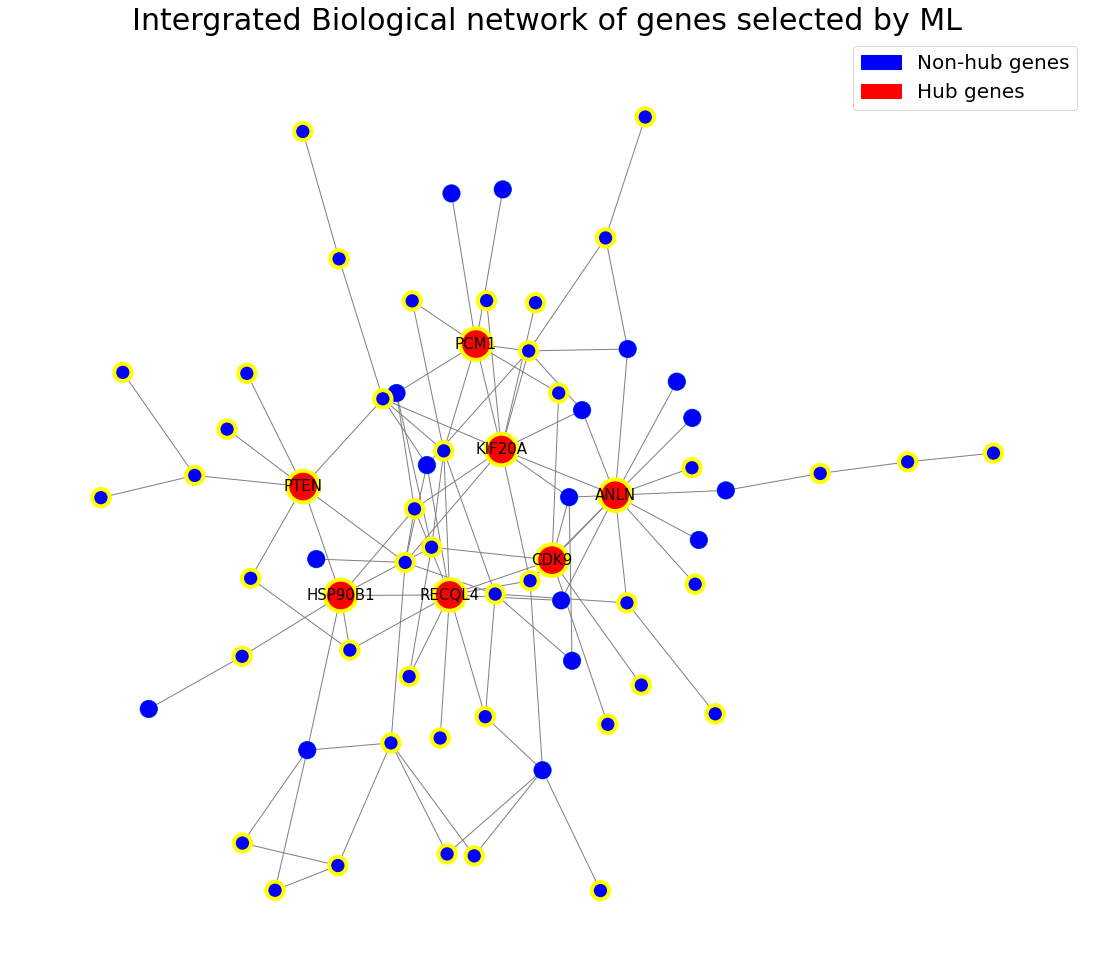

In [108]:
plt.figure(3,figsize=(15,13)) 
nx.draw(G_ML_main,pos,node_size = node_size_list,with_labels=False, edge_color="gray")
nx.draw_networkx_nodes(G_ML_main, pos,node_color=color_map,node_size = node_size_list, edgecolors = edgecolors_list, linewidths=4.0 )
nx.draw_networkx_labels(G_ML_main, pos, labels,font_size=15, font_color="k")
#plt.figtext(.02, .02, "The red circle of nodes indicate reported breast cancer association", fontsize = 20)
plt.title('Intergrated Biological network of genes selected by ML', fontsize = 30)
  # Creating legend with color box
blue_patch = mpatches.Patch(color='blue', label='Non-hub genes')
yellow_patch = mpatches.Patch(color='red', label='Hub genes')
plt.legend(handles=[blue_patch,yellow_patch],fontsize = 20)
plt.show()

In [54]:
count = 0
for i in ML_fixed_genes:
    if i in br_list:
        count +=1
        

In [55]:
count/len(ML_fixed_genes)

0.6232876712328768

In [56]:
count = 0
for i in G_ML_main.nodes():
    if i in br_list:
        count +=1
count/len(G_ML_main.nodes())        

0.746268656716418

In [58]:
count = 0
for i in degree_rank_hubs.keys():
    if i in br_list:
        count +=1
count/len(degree_rank_hubs.keys())        

1.0

In [71]:
import csv

hub_info = ['Gene_symbol', 'degree']
with open('ML_hubs.csv', 'w') as f:
    for key in degree_rank_hubs.keys():
        f.write("%s,%s\n"%(key,degree_rank_hubs[key]))

In [81]:
G_ML_main.edges
with open('ML_edges.csv', 'w') as f:
    for key in list(G_ML_main.edges()):
        f.write("%s,%s\n"%(key))
   

ValueError: I/O operation on closed file.

In [114]:
df = pd.DataFrame(data=(G_ML_main.edges()))
df.to_csv("./file1.csv", sep='\t',index=False)

In [112]:
G_ML_main.edges()

EdgeView([('TTF2', 'PRDX4'), ('TTF2', 'PCM1'), ('TTF2', 'BRCA2'), ('PRDX4', 'RECQL4'), ('PRDX4', 'HSP90B1'), ('PRDX4', 'KIF20A'), ('PRDX4', 'COPA'), ('CDK9', 'IL6ST'), ('CDK9', 'BRCA2'), ('CDK9', 'RRM2'), ('CDK9', 'RECQL4'), ('CDK9', 'HMGB3'), ('CDK9', 'DDX27'), ('CDK9', 'ANLN'), ('USP14', 'PSMB5'), ('USP14', 'CCNB1'), ('USP14', 'COPA'), ('USP14', 'RALA'), ('USP14', 'HMGN4'), ('PSMB5', 'RND1'), ('PSMB5', 'RECQL4'), ('USP13', 'CACYBP'), ('USP13', 'PTEN'), ('CACYBP', 'HSP90B1'), ('CACYBP', 'RECQL4'), ('RND1', 'GNAS'), ('RND1', 'FAM171A1'), ('RND1', 'DHCR7'), ('RND1', 'SLC39A6'), ('SHARPIN', 'PTEN'), ('SHARPIN', 'OTULIN'), ('SHARPIN', 'SKI'), ('PTEN', 'TRIM8'), ('PTEN', 'EZH2'), ('PTEN', 'COPA'), ('PTEN', 'HSP90B1'), ('PTEN', 'PURB'), ('PAN2', 'MYO5C'), ('PAN2', 'UACA'), ('PAN2', 'PCM1'), ('PAN2', 'CALD1'), ('PAN2', 'NUP50'), ('PAN2', 'KIF20A'), ('MYO5C', 'ANLN'), ('MYO5C', 'CALD1'), ('UACA', 'ANLN'), ('UACA', 'KIF20A'), ('PCM1', 'CCNB2'), ('PCM1', 'CEP95'), ('PCM1', 'KIF20A'), ('PCM1', '

In [87]:
l = 0
brc = 0
for i in ML_fixed_genes:
    if i not in G_ML_main.nodes():
        l +=1
        if i in br_list:
            brc +=1
brc/l

0.5189873417721519